## Introduction

In [2]:
# This imports most relevant libraries like panda, numpy etc
from fastai.imports import *
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from ipywidgets import interact

np.set_printoptions(linewidth=130)

## Data preprocessing

In [3]:
path = Path('titanic')

In [4]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [5]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    # Fill NAs with the most common value of each column
    df.fillna(modes, inplace=True)
    # Normalize the Fare with a log
    df['LogFare'] = np.log1p(df['Fare'])
    # Assign numerical values on categorical data.
    # We are not creating dummy variables but we have categories with numerical values
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [6]:
# Declare categories and continuous variables and dependent variable
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [7]:
# e.g. columns remain the same but now they have categories
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [8]:
# These are the numerical values of the categories
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

## Binary splits

c:\Users\eltar\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\eltar\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[Text(0.5, 1.0, 'Histogram')]

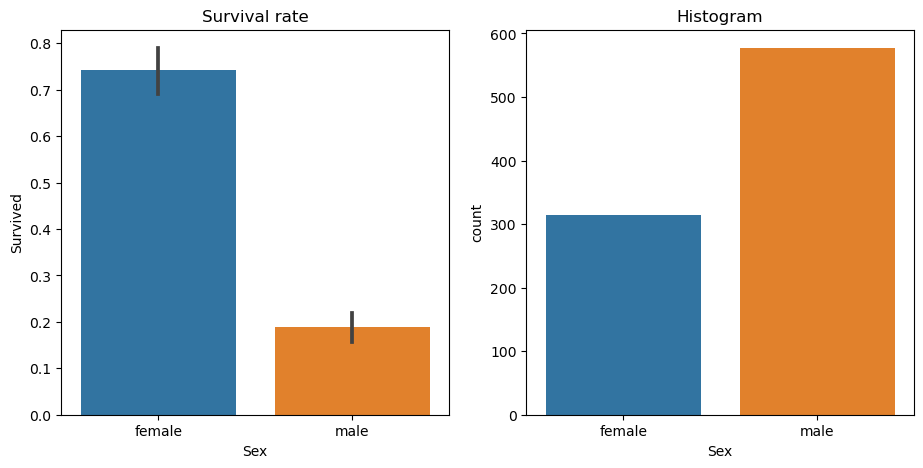

In [9]:
# (1,2) : the figure will have 1 row and 2 columns of subplots.
# figsize=(11,5) : sets the width and height of the figure in inches.
fig,axs = plt.subplots(1,2, figsize=(11,5))
# Create a bar plot on the first subplot (axs[0]).
# data=df : the DataFrame 
# y=dep and x="Sex" y variable and x variable.
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
# Create a count plot (a histogram) on the second subplot (axs[1]).
# This time, only the x-axis variable is specified,
# and the y-axis will represent counts of the Sex variable. 
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram")

In [10]:
# If created the simplest of models spliting by sex, that would be surprisingly good already

# Split in training and test sets
random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
# Apply the categories codes (convert to their codes)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [11]:
# Function that returns the xs and the ys
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [12]:
# Let's simply predict using Sex
preds = val_xs.Sex==0

In [13]:
mean_absolute_error(val_y, preds)
# 0.22 is already a pretty good error

0.21524663677130046

c:\Users\eltar\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\eltar\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\eltar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='LogFare', ylabel='Density'>

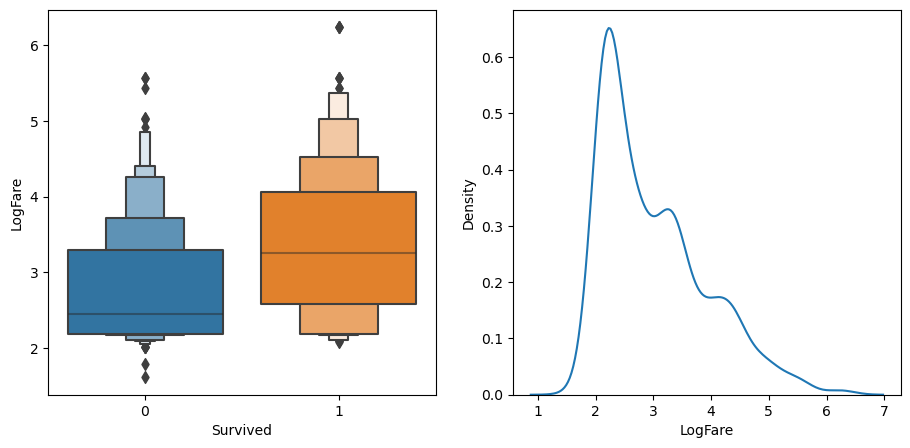

In [14]:
# Let's examine Fare
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
# Kernel Density plot (like a continuous histogram)
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1])
# We see that we can split a bit under 3.0

In [15]:
preds = val_xs.LogFare>2.7

In [16]:
mean_absolute_error(val_y, preds)
# 0.33 error is not good

0.336322869955157

In [17]:
# Here we create a little interactive tool to see the score of how good a binary split is
def _side_score(side, y):
    tot = side.sum()
    if tot<=1:
        return 0
    return y[side].std()*tot # the satndard deviation

In [18]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y) # sum stds / len | (~lhs) means not lhs

In [19]:
score(trn_xs["Sex"], trn_y, 0.5)
# lower score is better

0.4078753098206398

In [20]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.4718087395209973

In [21]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

interact(nm=conts, split=15.5)(iscore)

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

<function __main__.iscore(nm, split)>

In [22]:
interact(nm=cats, split=2)(iscore)

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

<function __main__.iscore(nm, split)>

In [23]:
# Let's try to automate this, here for Age
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [24]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [25]:
# So, this calculates the best split for a column
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.47831671750899085)

In [26]:
cols = cats+conts
# Calculate the best splits for each column
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

## Creating a decision tree

In [27]:
# Let's try to further split on another column by removing Sex
# and splitting to males and females
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [28]:
{o:min_col(males, o) for o in cols}
# Age seems the best option males

{'Embarked': (0, 0.387558187041091),
 'Age': (6.0, 0.37398283710105873),
 'SibSp': (4, 0.38758642275862637),
 'Parch': (0, 0.3874704821461953),
 'LogFare': (2.803360380906535, 0.38048562317581447),
 'Pclass': (1, 0.3815544200436083)}

In [29]:
{o:min_col(females, o) for o in cols}
# Pclass seems the best option for females

{'Embarked': (0, 0.4295252982857326),
 'Age': (50.0, 0.4225927658431646),
 'SibSp': (4, 0.42319212059713585),
 'Parch': (3, 0.4193314500446157),
 'LogFare': (4.256321678298823, 0.413505983329114),
 'Pclass': (2, 0.3335388911567602)}

In [30]:
# This time, we will use a Decision Tree (sklearn.tree.DecisionTreeClassifier) to do the job for us
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [31]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

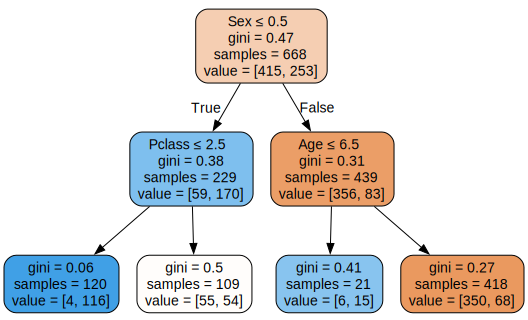

In [32]:
# For this you also need to install Graphviz executable from https://graphviz.org/download/
# and restart your IDE
draw_tree(m, trn_xs, size=10)
# We see that 116 1st class females survived and 68 males above 6 years old
# The decision tree found the same splits as we did

In [33]:
# The default split criterion of DecisionTreeClassifier is 'gini'
# This is what gini actually is for a binary case.
# The probability of a row value being 1 or 0
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [34]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [35]:
# So for the above Decision Tree the error is:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

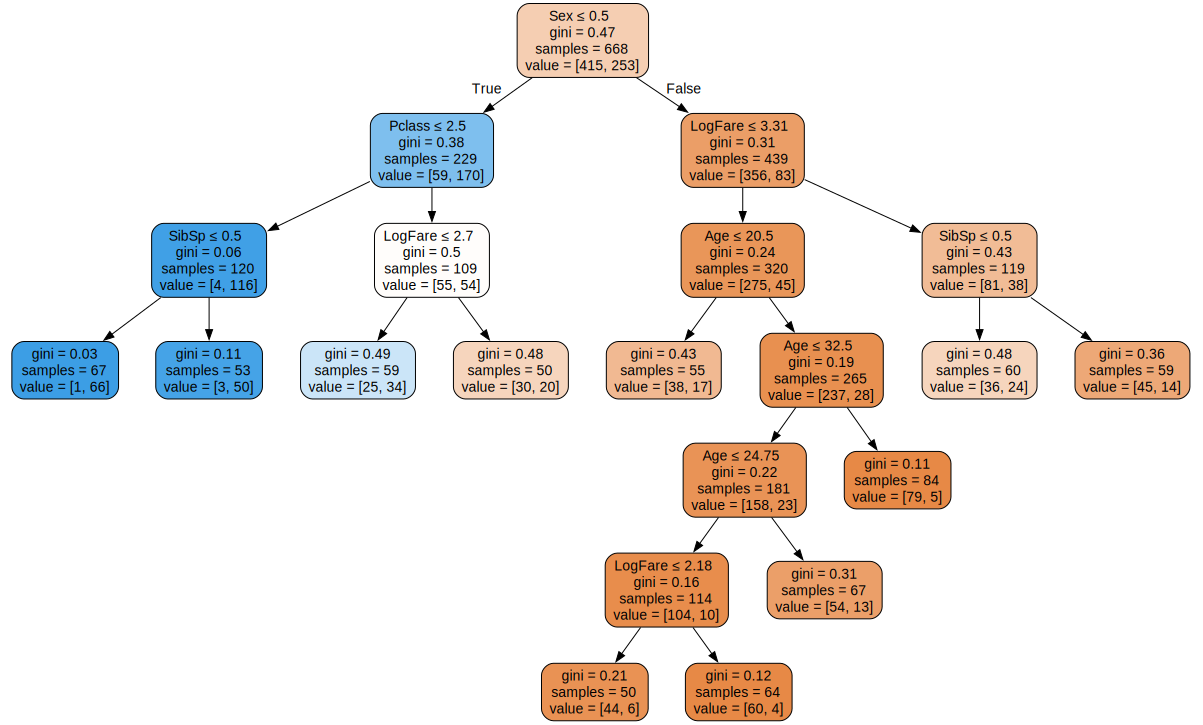

In [36]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [37]:
# For this bigger Decision Tree the error is:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

In [38]:
# Save the results
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [39]:
# Decision Trees do not really need dummy variables or normalization as they handle this through splitting
df.Embarked.head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [40]:
df.Embarked.cat.codes.head()

0    2
1    0
2    2
3    2
4    2
dtype: int8

## The random forest

In [41]:
# By using a lot of not perfect
# unbiased and not correlated Decision Trees together (enseble)
# on random subsets of the data,
# we can average the errors.
# The average of a lot of uncoreleted random errors is zero!

# The function that creates a tree from a random subset of the data
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [42]:
# Create 100 trees
trees = [get_tree() for t in range(100)]

In [43]:
# Average the results
all_probs = [t.predict(val_xs) for t in trees] # list of vectors
avg_probs = np.stack(all_probs).mean(0)

In [44]:
# The error
mean_absolute_error(val_y, avg_probs)

0.2272645739910314

In [54]:
# We can do the same with sklearn RandomForestClassifier,
# but in reality Random Forests also select a random subset of columns for every tree
rf = RandomForestClassifier(100, min_samples_leaf=5, oob_score = True)
rf.fit(trn_xs, trn_y);

In [55]:
# So the actual error is better
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

In [56]:
# Save the results
subm(rf.predict(tst_xs), 'rf')

<Axes: ylabel='cols'>

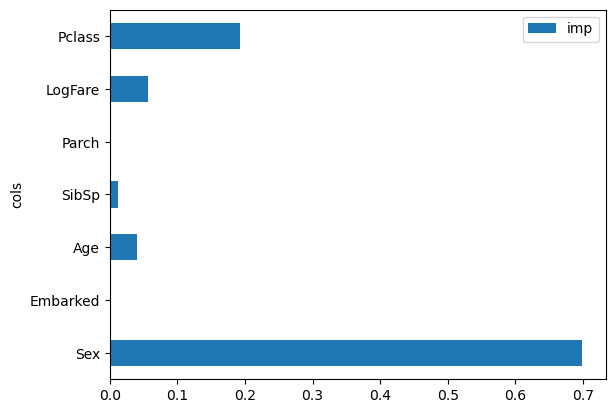

In [57]:
# Here we can see the importance of each column
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh')

In [60]:
# This is the accuracy whilst evaluating.
# This is useful, because most of the time
# we can get away with training Random Forests on the whole dataset
# without keeping a validation set.
# Makes sense, as each tree gets a random subset (not the whole dataset).
rf.oob_score_

0.8173652694610778